# Wildfire Classification

In [23]:
### photo here ###

### Overview
Wildfires are highly unpredictable natural disasters. They can be sparked by a variety of factors (human carelessness, arson, lightning, etc.), and spread and behave differently based on a myriad of different “ingredients.” Any one of these ingredients can change at a moment’s notice taking a fire from small and almost contained, to unwieldy and catastrophic. The effects of global climate change have only exacerbated the factors we know to be conducive to large wildfires, namely heat, drought, and high winds. While wildfires can occur almost anywhere at any time, there are certainly circumstances that make a wildfire more threatening. 

According to the [National Interagency Fire Center (NIFC)](https://www.nifc.gov/), in the US we are experiencing not only more fires every year, but bigger, more destructive fires. Since 1999 the US has documented an average of more than 60,000 wildfires that total about 3 million acres burned per year. At peak season, wildfires become so prevalent that there are not enough resources or firefighters to tend to every single call (particularly in the Western half of the United States), forcing firefighters to make high stakes decisions about which fires are more likely to become the most dangerous. With this in mind we set out to classify wildfires as either "small" or "large" to aid in this decision making process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV, chi2, f_classif, mutual_info_classif
 
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('forest_fire.csv')

### The Data
The [dataset](https://www.kaggle.com/capcloudcoder/us-wildfire-data-plus-other-attributes) was compiled on Kaggle from the Fort Collins, CO: Forest Service Research Data Archive about wildfires across the US (& PR) from 1992 - 2015, NOAA National Centers for Environmental Information, and supplemented from two other sources. **We wanted to create a highly interpretable, predictive model to help firefighters classify wildfires from less dangerous to more dangerous (small or large).** The National Wildfire Coordinating Group (NWCG) uses a retroactive [classification metric](https://www.nwcg.gov/term/glossary/size-class-of-fire#:~:text=As%20to%20size%20of%20wildfire,one%2Dfourth%20acre%20or%20less%3B&text=Class%20F%20%2D%201%2C000%20acres%20or,G%20%2D%205%2C000%20acres%20or%20more) of "A-G" where "A" is the smallest fires burning anything under ¼ of an acre, and "G" being the largest class of fires burning a *minimum* of 5,000 acres. 

The dataset includes features about what caused a fire, weather conditions leading up to the start of the fire, and geographical data about the type of environment most prevalent at the site of a fire. If firefighters are able to forecast a fire's potential to become "large" based on these factors and a few that we engineered from the data, they will be able to make faster prioritizations and real-time decisions about where and when to allocate their limited resources.

In [4]:
# this block of code takes care of null values and unusable data
df = df[df['Temp_cont'] != -1]

to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'fire_name',
           'cont_clean_date', 'disc_date_final', 'cont_date_final', 
           'putout_time', 'disc_date_pre', 'disc_pre_year', 
           'disc_pre_month', 'wstation_usaf', 'dstation_m',
           'wstation_wban', 'wstation_byear', 'wstation_eyear',
           'fire_mag', 'weather_file', 'Temp_cont', 'Hum_cont',
           'Wind_cont', 'Prec_cont']

df = df.drop(labels=to_drop, axis=1)

# convert temperatures from C to F
def c_to_f(c):
    return (c * 9/5) + 32

df.loc[:,'Temp_pre_30':'Temp_pre_7'] = df.loc[:,'Temp_pre_30':'Temp_pre_7'].applymap(lambda x: c_to_f(x))

# remove rows where 'missing values' that have been replaced by 0C/32F
df = df[(df.Temp_pre_30!=float(32))]
df = df[(df.Temp_pre_15!=float(32))]
df = df[(df.Temp_pre_7!=float(32))]

# the target variable: 0 = fires less than 100 acres, 1 = fires bigger than 100 acres
df['target'] = np.where(df['fire_size'] <= 100,0,1)

df.shape

(36535, 23)

### Exploratory Data Analysis & Feature Engineering
To make this a binary classification problem, we separated the target variable fire_size into small fires (0, negative class), and large fires (1, positive class). The cutoff for these was fires classified as A, B, or C (i.e. less than 100 acres burned), and fires that burn larger than 100 acres. This left us with a fairly large class imbalance with about 84% of our data occurring in the negative class. This class imbalance varies from state to state, with large wildfires occurring at higher rates in the south and western parts of the US.

In [34]:
colors = ['#AFADAD', '#FA4949']

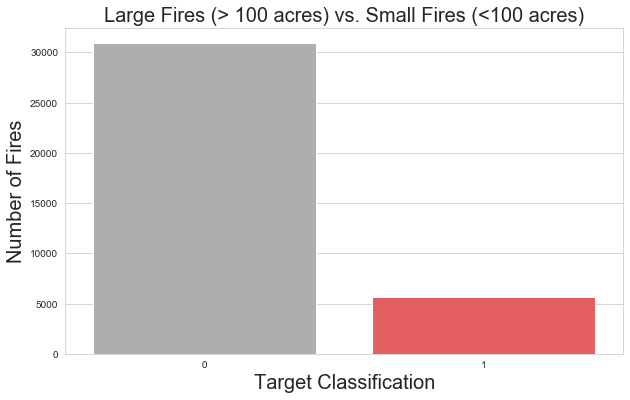

In [35]:
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette(colors))
sns.countplot(df['target'])
plt.title('Large Fires (> 100 acres) vs. Small Fires (<100 acres)', fontsize=20)
plt.xlabel('Target Classification', fontsize=20)
plt.ylabel('Number of Fires', fontsize=20)
plt.show()

This scatter plot below maps out the locations of each instance in our dataset and labels the large fires orange and the smaller fires blue. As is evident from the plot, the vast majority of our target class occur in the western United States, including and particularly in Alaska. We created a feature called 'west_coast' to indicate whether a state is west of the -100 longitudinal line.

In [15]:
df['west_coast'] = df.longitude.apply(lambda x: 1 if x < -100 else 0)

In [14]:
### need to fix up labels and legend ###

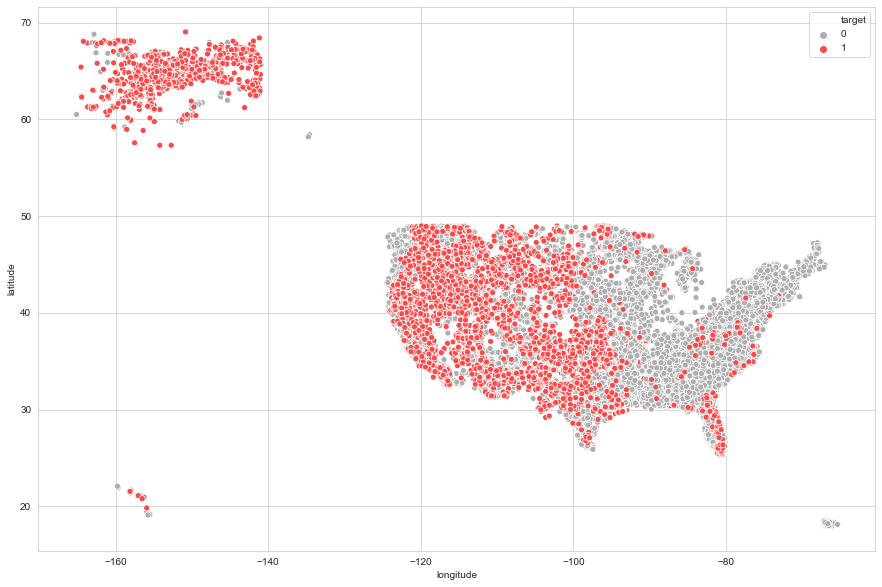

In [37]:
sns.set_style("whitegrid")

x = df.longitude
y = df.latitude

fig = plt.figure(figsize=(15,10))
ax = fig.subplots
ax = sns.scatterplot(x=x, y=y,
              hue=df.target,
              data=df,
              legend='full');

From what we hear and see on the news, we know that Summer is known as wildfire season on the West Coast. Summer evidently provides wildfires with the ideal conditions to thrive. This was reflected in our data. You see below that while there might not be more occurences of wildfires during the Summer, there are undoubtedly more "large" wildfires that take place in Summer.

In [17]:
# parsing out the month
df['month'] = df['discovery_month'].apply(lambda x: 
                                         1 if x == 'Jan'
                                          else 2 if x == 'Feb'
                                          else 3 if x == 'Mar'
                                          else 4 if x == 'Apr'
                                          else 5 if x == 'May'
                                          else 6 if x == 'Jun'
                                          else 7 if x == 'Jul'
                                          else 8 if x == 'Aug'
                                          else 9 if x == 'Sep'
                                          else 10 if x == 'Oct'
                                          else 11 if x == 'Nov'
                                          else 12
                                         )

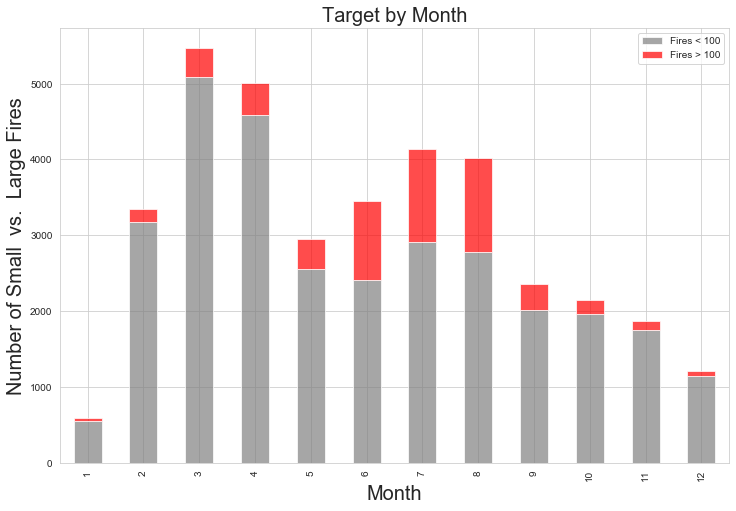

In [21]:
month_viz = df.groupby(['month', 'target']).month.count().unstack()

p1 = month_viz.plot(kind='bar', stacked=True, color=['grey', 'red'], alpha=.70, figsize=(12,8))
p1.set_title('Target by Month', fontsize=20)
p1.set_xlabel('Month', fontsize=20)
p1.set_ylabel('Number of Small  vs.  Large Fires', fontsize=20)
p1.legend(['Fires < 100', 'Fires > 100'])
plt.show()

In [ ]:
# df = pd.read_csv('cleaned_fire_data.csv')